Welcome to the VICE tutorial! 
=============================

Keeping true to its name, VICE is highly versatile, allowing users to specify their own nucleosynthetic yields for various elements independent of supernova nucleosynthesis studies; these can even be functions of metallicity! VICE also affords users the ability to construct arbitrary mathematical functions to describe many evolutionary parameters, including the star formation history, inflow metallicities, star formation efficiency, and more. 

If you haven't installed VICE, this can be done via ``pip install vice`` in a ``Unix`` terminal. Instructions for alternate installation methods can be found at https://vice-astro.readthedocs.io/en/latest/install.html. If you're viewing this tutorial in a web browser but would like a local copy, you can do so by cloning the VICE repository from GitHub and launching ``jupyter`` from the command line: 

``git clone https://github.com/giganano/VICE.git`` 

``cd VICE`` 

``make tutorial`` or ``jupyter notebook examples/QuickStartTutorial.ipynb`` 

Before diving in, all users should be aware that VICE's documentation is available online at https://vice-astro.readthedocs.io. Assuming VICE is installed, the terminal command ``vice --docs`` will automatically open a web browser to that page. Users should also be aware of the science documentation, accessible from the main documentation's home page. In the bottom right, users may click on the ``v: latest`` button to download a PDF copy if they so choose. Standard documentation of the package contents in their entirety is available through the comprehensive API reference, also accessible from the home page. As is common practice in python packages, this material is also available in the docstring embedded within the code itself. 

We've organized this tutorial in a modular manner based on the science interests of the user: 

**Table of Contents**: 
- [Yield Calculations](#yield_calculations) 
    - [Core Collapse Supernovae](#yield_calculations_ccsn) 
    - [Type Ia Supernovae](#yield_calculations_snia) 
    - [Asymptotic Giant Branch Stars](#yield_calculations_agb) 
    - [The Global Yield Settings](#yield_calculations_globals) 
    - [Yield Presets](#yield_calculations_presets) 
- [Single Stellar Populations](#ssps) 
- [One-Zone Models](#onezonemodels) 
    - [One-Zone Model Outputs](#onezonemodels_outputs) 
- [Migration Prescriptions](#migration) 
- [Multi-Zone Models](#multizonemodels) 
    - [Milky Way Models](#multizonemodels_milkyway) 
- [Useful Built-in Data](#useful_data) 

In general, each section builds on the previous sections and assumes that the user has familiarized themselves with that material, but no instruction is duplicated. Users are welcome to go about this tutorial however they desire, but should be aware of this if they choose to skip pieces of the tutorial. For example, users electing to skip to the [One-Zone Models](#onezonemodels) section should be aware that [The Global Yield Settings](#yield_calculations_globals) demonstrates how they can modify their adopted nucleosynthetic yields. 

In [1]:
import numpy as np # we'll use NumPy for this demonstration, but VICE does not need it. 
import warnings # we'll ignore warnings for the sake of the tutorial as well. 
warnings.filterwarnings("ignore") 
import math 
import vice 

<a id="yield_calculations"></a> 
Yield Calculations 
------------------
Users can calculate nucleosynthetic yields using built-in tables from supernova nucleosynthesis studies with the ``vice.yields`` module. Within this, they'll find the ``vice.yields.agb``, ``vice.yields.ccsne``, ``vice.yields.sneia``, and ``vice.yields.presets`` modules. 

<a id="yield_calculations_ccsn"></a> 
Core Collapse Supernovae 
------------------------
Let's start with some core collapse supernova (CCSN) yield calculations. To calculate an IMF-averaged yield of a given element, users should call ``vice.yields.ccsne.fractional``. For example, one calculation of an iron (Fe) yield: 

In [2]:
print(vice.yields.ccsne.fractional('fe')) 

[0.0006230175041680501, 6.331704025860192e-07]


The values returned from this function represent the mass of Fe produced by all CCSNe associated with a progenitor stellar population in units of that stellar population's total mass, and the estimated numerical error on this value. For example, given this value, a 100 solar mass star cluster would produce 0.06 solar masses of Fe from all of its CCSNe. 

By default, this function assumes the yield tables of Limongi & Chieffi (2018) at solar metallicity for non-rotating progenitor models. These parameters can be modified with the keyword arguments ``study``, ``MoverH``, and ``rotation``. For example, the iron yield calculated using the Nomoto, Kobayashi & Tominaga (2013) yields near solar metallicity, and for rotational velocities of 300 km/s at solar metallicity reported by Chieffi & Limongi (2013): 

In [3]:
print(vice.yields.ccsne.fractional('fe', study = "NKT13", MoverH = 0.15)) 
print(vice.yields.ccsne.fractional('fe', study = "CL13", rotation = 300)) 

[0.0005849348049959557, 7.592014641978583e-07]
[0.0010823375570382472, 1.083067843315522e-06]


By default, this function assumes a Kroupa (2001) initial mass function (IMF). VICE has built-in functional forms for this as well as the classic Salpter (1955) IMF, but users may construct their own IMFs as well. For example, a simple modification of the Salpeter single power-law IMF: 

In [4]:
def my_imf(mass): 
    r""" 
    A user-defined IMF must take stellar mass in solar masses as the 
    only parameter. They do not need to be normalized in any way. 
    """ 
    return mass**-2  
print(vice.yields.ccsne.fractional('fe', IMF = my_imf)) 
print(vice.yields.ccsne.fractional('fe', IMF = "salpeter")) 

[0.0009486527435871065, 3.570971879865603e-07]
[0.00038599529121957366, 1.0892319154108284e-07]


Users may also compute yields under various assumptions about stellar explodability. A few of the popular options from the Sukhbold et al. (2016) study are available under ``vice.yields.ccsne.engines``. Users may also construct their own versions as a callable function of mass; these must return values between 0 and 1, denoting the fraction of stars of a given mass that produce a CCSN event. 

For example, a simple mass cutoff at 40 solar masses, and the W18 explosion engine from Sukhbold et al. (2016), but both adopting the seminal yield set of Woosley & Weaver (1995): 

In [5]:
def my_explodability(mass): 
    r""" 
    Stars up to 40 solar masses explode, otherwise no supernova. 
    """ 
    return int(mass <= 40) 
print(vice.yields.ccsne.fractional('fe', study = "WW95", explodability = my_explodability)) 
print(vice.yields.ccsne.fractional('fe', study = "WW95", 
    explodability = vice.yields.ccsne.engines.S16.W18)) 

[0.0009787174257993062, 1.0152196973467546e-06]
[0.0005190637925550223, 5.14707127049084e-07]


Users may also distinguish between the yields inclucing or excluding stellar winds, as well as net versus gross yields. By default, winds are included and the calculations are ran for net yields. For example, the yields calculated from the N20 explosion engine from Sukhbold et al. (2016): 

In [6]:
print(vice.yields.ccsne.fractional('fe', study = "S16/N20", wind = True, net = True)) 
print(vice.yields.ccsne.fractional('fe', study = "S16/N20", wind = True, net = False)) 
print(vice.yields.ccsne.fractional('fe', study = "S16/N20", wind = False, net = True)) 
print(vice.yields.ccsne.fractional('fe', study = "S16/N20", wind = False, net = False)) 

[0.0005915744337072646, 5.990962041041991e-07]
[0.0008785010934835543, 1.019536948946182e-06]
[0.0004780124386632339, 4.89374786970288e-07]
[0.0007649390851818777, 9.114762056504661e-07]


For a breakdown of all parameters allowed by this function, users should familiarize themselves with the documentation, available online here: https://vice-astro.readthedocs.io/en/latest/users_guide/pkgcontents/vice.yields.ccsne.fractional.html

The ``vice.yields.ccsne`` module also provides the ``table`` function, which runs a simple lookup of the yield table reported by a given study. It takes keyword arguments similar to that of ``vice.yields.ccsne.fractional``. For example: 

In [7]:
table = vice.yields.ccsne.table('o', study = "CL13") 
print(table) 

vice.dataframe{
    13.0 -----------> 0.204957
    15.0 -----------> 0.505658
    20.0 -----------> 1.3048579999999999
    25.0 -----------> 2.303057
    30.0 -----------> 3.801041
    40.0 -----------> 6.000364
    60.0 -----------> 8.20037
    80.0 -----------> 12.000356
    120.0 ----------> 18.000428000000003
}


This function returns an instance of the VICE ``dataframe``, a dictionary-like object it uses to store its internal data. All it's doing here is mapping the progenitor masses to their mass yields in $M_\odot$: 

In [8]:
print(table[13]) 
print(table[30]) 

0.204957
3.801041


The masses themselves can be accessed without a print statement via its attribute: 

In [9]:
print(table.masses) 
print([table[i] for i in table.masses]) # the yields 

(13.0, 15.0, 20.0, 25.0, 30.0, 40.0, 60.0, 80.0, 120.0)
[0.204957, 0.505658, 1.3048579999999999, 2.303057, 3.801041, 6.000364, 8.20037, 12.000356, 18.000428000000003]


The ``vice.yields.ccsne.table`` function also allows the full isotopic breakdown of the yield to be returned as opposed to only the mass yields. Modifying our previous example: 

In [10]:
table = vice.yields.ccsne.table('o', study = "CL13", isotopic = True) 
print(table) 
print(table[13]['o16']) 
print(table[80]['o18']) 
print(table[table.masses[3]]) 

vice.dataframe{
    13 -------------> {'o16': 0.2, 'o17': 5.7e-05, 'o18': 0.0049}
    15 -------------> {'o16': 0.5, 'o17': 5.8e-05, 'o18': 0.0056}
    20 -------------> {'o16': 1.3, 'o17': 5.8e-05, 'o18': 0.0048}
    25 -------------> {'o16': 2.3, 'o17': 5.7e-05, 'o18': 0.003}
    30 -------------> {'o16': 3.8, 'o17': 6.1e-05, 'o18': 0.00098}
    40 -------------> {'o16': 6.0, 'o17': 6.4e-05, 'o18': 0.0003}
    60 -------------> {'o16': 8.2, 'o17': 0.00014, 'o18': 0.00023}
    80 -------------> {'o16': 12.0, 'o17': 9.6e-05, 'o18': 0.00026}
    120 ------------> {'o16': 18.0, 'o17': 9.8e-05, 'o18': 0.00033}
}
0.2
0.00026
vice.dataframe{
    o16 ------------> 2.3
    o17 ------------> 5.7e-05
    o18 ------------> 0.003
}


<a id="yield_calculations_snia"></a> 
Type Ia Supernovae
------------------
Let's continue with some Type Ia supernova (SN Ia) calculations. VICE has built-in tables from the Iwamoto (1999) and Seitenzahl et al. (2013) studies, and can calculate IMF-averaged as well as single detonation yields. For example, the Fe yield from the W70 and WDD1 models from Iwamoto (1999) and the N20 and N150 models from Seitenzahl et al. (2013): 

In [11]:
print(vice.yields.sneia.fractional('fe', study = "iwamoto99", model = "W70")) 
print(vice.yields.sneia.fractional('fe', study = "iwamoto99", model = "WDD1")) 
print(vice.yields.sneia.fractional('fe', study = "seitenzahl13", model = "N20")) 
print(vice.yields.sneia.fractional('fe', study = "seitenzahl13", model = "N150")) 

0.001705352
0.001478026
0.0019366021400000002
0.0015531131


This function returns a single value with no numerical error, because the solution is analytic. The supernova study reports mass yields for single detonations, and the ``fractional`` function assumes 2.2e-3 SN Ia events per solar mass of star formation. This can be adjusted using the keyword argument ``n``: 

In [12]:
print(vice.yields.sneia.fractional('fe')) 
print(vice.yields.sneia.fractional('fe', n = 3e-3)) 
print(vice.yields.sneia.fractional('fe', n = 2e-3)) 

0.0025825957080000002
0.0035217214200000003
0.0023478142800000003


Users can also lookup the mass yield of a single detonation under any available explosion model. The returned values are always in solar masses. The keyword arguments are otherwise the same, without the option to specify ``n``: 

In [13]:
print(vice.yields.sneia.single('fe', study = "iwamoto99", model = "W70")) 
print(vice.yields.sneia.single('fe', study = "iwamoto99", model = "WDD1")) 
print(vice.yields.sneia.single('fe', study = "seitenzahl13", model = "N20")) 
print(vice.yields.sneia.single('fe', study = "seitenzahl13", model = "N150")) 

0.77516
0.6718299999999999
0.8802737
0.7059605


<a id="yield_calculations_agb"></a> 
Asymptotic Giant Branch Stars 
-----------------------------
VICE stores built-in tables from the Cristallo et al. (2011) and Karakas (2010) asymptotic giant branch (AGB) star nucleosynthesis studies. They can be read in for a specific element directly via ``vice.yields.agb.grid``. The only keyword argument is accepts is the study (default: "cristallo11"), and it returns the yields, masses, and metallicities associated with their reported table. For example, their reported carbon (C) yields: 

In [14]:
y1, m1, z1 = vice.yields.agb.grid("c") 
y2, m2, z2 = vice.yields.agb.grid("c", study = "karakas10") 
print(m1) 
print(z1) 
print(y1[0]) 
print(y1[1]) 
print(m2) 
print(z2) 
print(y2[0]) 
print(y2[1]) 

(1.3, 1.5, 2.0, 2.5, 3.0, 4.0, 5.0, 6.0)
(0.0001, 0.0003, 0.001, 0.002, 0.003, 0.006, 0.008, 0.01, 0.014, 0.02)
(0.00233122, 0.00206212, 0.00163226, 0.00150313, 0.000781408, 0.000406231, -5.03077e-05, -0.000150308, -0.000317615, -0.000422)
(0.00550038, 0.00402732, 0.00326823, 0.00311003, 0.0021181, 0.00186327, 0.00110053, 0.001111, 0.0007376, 0.0003892)
(1.0, 1.25, 1.5, 1.75, 1.9, 2.25, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0)
(0.0001, 0.004, 0.008, 0.02)
(0.000250197, -3.861e-05, -6.944e-05, -0.0001502)
(0.00297639, 5.8632e-05, -0.00015008, -0.0003392)


The yields are returned in a 2-D tuple, with stellar mass as the first axis of indexing and metallicity the second. For example, the metallicity at the lowest mass but third lowest metallicity would be found at ``y[0][2]``. As with the SN Ia and CCSN yields, these are *fractional* yields in that the absolute yield in solar masses is given by these values multiplied by progenitor mass (e.g. ``m[0] * y[0][2]``). 

<a id="yield_calculations_globals"></a> 
The Global Yield Settings 
-------------------------
Within the ``yields`` modules, users should declare the values that will adopt in one-zone and multi-zone models. Each module stores a ``settings`` object containing each recognized element's current yield. For example, the current CCSN, SN Ia, and AGB yields of C, Fe, and oxygen (O): 

In [15]:
print(vice.yields.ccsne.settings['c']) 
print(vice.yields.ccsne.settings['fe']) 
print(vice.yields.ccsne.settings['o']) 
print(vice.yields.sneia.settings['c']) 
print(vice.yields.sneia.settings['fe']) 
print(vice.yields.sneia.settings['o']) 
print(vice.yields.agb.settings['c']) 
print(vice.yields.agb.settings['fe']) 
print(vice.yields.agb.settings['o']) 

0.00236
0.000246
0.00564
5.74e-06
0.00258
5.79e-05
cristallo11
cristallo11
cristallo11


The string "cristallo11" in the AGB yield settings means VICE will adopt the Cristallo et al. (2011) yields sampled on a table of masses and metallicities, linearly interpolating between table elements. Users may modify these values directly, even constructing functions of metallicity to describe supernova yields. In the case of AGB star yields, functions accepting progenitor mass and metallicity (in that order) can be constructed as well. For example: 

In [16]:
def zdep_ccsn_yield(z): 
    r""" 
    The metallicity must be the abundance by mass, Z = M_z / M_\star. 
    """ 
    return 0.001 * (z / 0.014) # some simple function form for demonstration purposes 
def zdep_snia_yield(z): 
    return 2.e-5 * (z / 0.02) 
def custom_agb_yield(mass, z): 
    return mass / 100 * (z / 0.014)**2 

vice.yields.ccsne.settings['c'] = 0.002 
vice.yields.sneia.settings['c'] = 0.0005 
print(vice.yields.ccsne.settings['c']) 
print(vice.yields.sneia.settings['c']) 
vice.yields.ccsne.settings['c'] = zdep_ccsn_yield 
vice.yields.sneia.settings['c'] = zdep_snia_yield 
vice.yields.agb.settings['c'] = custom_agb_yield 
print(vice.yields.ccsne.settings['c']) 
print(vice.yields.sneia.settings['c']) 
print(vice.yields.agb.settings['c'])

0.002
0.0005
<function zdep_ccsn_yield at 0x7fa2c85863b0>
<function zdep_snia_yield at 0x7fa2c8586290>
<function custom_agb_yield at 0x7fa2c85860e0>


VICE will adopt the current global yield settings when one-zone and multi-zone models are ran. Although it includes this functionality with which to calculate yields, users are not restricted to any of the values reported by the ``yields`` module. It is there to help, but users may exercise their own discretion over their yields in their chemical evolution models. 

<a id="yield_calculations_presets"></a> 
Yield Presets 
-------------
Although VICE does not restrict users to any given set of nucleosynthetic yields, they are able to if they so choose by simply importing built-in modules, as well as saving their own custom yield sets. For example, the global yield settings can be modified to reflect the Nomoto, Kobayashi & Tominaga (2013) by importing the ``NKT13`` module from ``vice.yields.ccsne``. The same can be done for the ``sneia`` and ``agb`` models as well. 

In [17]:
print(vice.yields.ccsne.settings['c']) 
print(vice.yields.sneia.settings['c']) 
print(vice.yields.agb.settings['c']) 
from vice.yields.ccsne import NKT13 
from vice.yields.sneia import seitenzahl13 
from vice.yields.agb import karakas10 
print(vice.yields.ccsne.settings['c']) 
print(vice.yields.sneia.settings['c']) 
print(vice.yields.agb.settings['c']) 

<function zdep_ccsn_yield at 0x7fa2c85863b0>
<function zdep_snia_yield at 0x7fa2c8586290>
<function custom_agb_yield at 0x7fa2c85860e0>
0.0010140707812355703
5.7420404800000006e-06
karakas10


The yields for all elements can be updated easily by calling the ``set_params`` function of each imported module and passing the same keyword arguments that would be given to ``vice.yields.ccsne.fractional`` and ``vice.yields.sneia.fractional``. For example, updating the NKT13 yields to adopt the W18 black hole landscape from Sukhbold et al. (2016), and switching to the N40 model from Seitenzahl et al. (2013): 

In [18]:
# MoverH = 0.15 simply because NKT13 doesn't report yields at *exactly* solar metallicity 
NKT13.set_params(explodability = vice.yields.ccsne.engines.S16.W18, MoverH = 0.15) 
seitenzahl13.set_params(model = "N40") 
print(vice.yields.ccsne.settings['c']) 
print(vice.yields.sneia.settings['c']) 

0.000580575984119377
8.58004796e-06


Users may also construct their own ``.py`` files containing their declared yields and save them within VICE, making them available through the ``vice.yields.presets`` module. For example, calling ``vice.yields.presets.save("example.py")`` will make the file ``example.py`` accessible via ``from vice.yields.presets import example``. VICE provides the default oxygen, iron, and strontium yields from the Johnson & Weinberg (2020) paper at ``vice.yields.presets.JW20`` as a built-in. Presets can be removed from this functionality by calling ``vice.yields.presets.remove`` and again passing the name of the ``.py`` file. 

At any given time, the installed presets can also be viewed by calling ``vice.yields.presets.remove`` with a dummy, non-existent file name, deliberately generating an error message which will tell the user which presets they've installed: 

In [19]:
try: 
    vice.yields.presets.remove("foo") 
except Exception as exc: 
    print(exc) 

Preset yield module not found: foo.py. Currently installed presets: 
		JW20.py


If you're going through this tutorial and have only just installed VICE, the ``JW20.py`` file containing the ``JW20`` yields will be the only available preset. Users who intend to make use of this functionality should be aware that the ``vice.yields.presets.remove`` function will stop and ask for confirmation that they'd like a file removed from their system; this can be pre-approved by adding the keyword argument ``force = True``. 

**Note**: On some operating systems, the ``vice.yields.presets.save`` and ``vice.yields.presets.remove`` function requires admin privileges. If you are not allowed to run processes as ``root`` on your machine, we can't guarantee that your environment will allow this functionality. 

<a id="ssps"></a>
Single Stellar Populations 
--------------------------
Contrary to the one-zone chemical evolution models which model enrichment from many stellar populations, sometimes it's of scientific interest to think about what enrichment as a function of time looks like from only one. To fulfill this purpose, VICE provides the ``single_stellar_population`` function. Its usage is straight-forward: give it an element, and keyword arguments specifying the mass of the star cluster, its metallicity, how much time to calculate enrichment for, and other parameters like the initial mass function and Type Ia supernova delay-time distribution, and it will return the net mass produced of the element and the times at which those mass yields were calculated. 

In [20]:
fe, time = vice.single_stellar_population('fe', mstar = 1e4, Z = 0.01, time = 10) 
print("A 10^4 Msun star cluster at Z = 0.01 produced %.2e Msun of iron after 10 Gyr." % (fe[-1])) 
sr, time = vice.single_stellar_population('sr', mstar = 1e4, Z = 0.007, time = 8.5) 
print("A 10^4 Msun star cluster at Z = 0.007 produced %.2e Msun of strontium after 8.5 Gyr." % (sr[-1])) 

A 10^4 Msun star cluster at Z = 0.01 produced 1.91e+01 Msun of iron after 10 Gyr.
A 10^4 Msun star cluster at Z = 0.007 produced 2.52e-04 Msun of strontium after 8.5 Gyr.


<a id="onezonemodels"></a> 
One-Zone Models 
---------------
VICE provides the ``singlezone`` class, an object which is explicitly designed to run one-zone models of galactic chemical evolution. The attributes of the class encode the evolutionary parameters the user wishes to build into their model. Each attribute can be initialized as a keyword argument upon creation of a ``singlezone`` object, or by modifying the current state of some attribute afterward. 

In [21]:
example = vice.singlezone(name = "example") # alternatively, sz = vice.singlezone(), then sz.name = "example" 
print(example) 

vice.singlezone{
    name -----------> example
    func -----------> <function _DEFAULT_FUNC_ at 0x7fa2682dc4d0>
    mode -----------> ifr
    verbose --------> False
    elements -------> ('fe', 'sr', 'o')
    IMF ------------> kroupa
    eta ------------> 2.5
    enhancement ----> 1.0
    entrainment ----> <entrainment settings>
    Zin ------------> 0.0
    recycling ------> continuous
    delay ----------> 0.15
    RIa ------------> plaw
    Mg0 ------------> 6000000000.0
    smoothing ------> 0.0
    tau_ia ---------> 1.5
    tau_star -------> 2.0
    schmidt --------> False
    schmidt_index --> 0.5
    MgSchmidt ------> 6000000000.0
    dt -------------> 0.01
    m_upper --------> 100.0
    m_lower --------> 0.08
    postMS ---------> 0.1
    Z_solar --------> 0.014
    bins -----------> [-3, -2.95, -2.9, ... , 0.9, 0.95, 1]
}


The following table provides first-time users with a quick breakdown of which attributes provide VICE with which component of the chemical evolution model: 

| Attribute  | Description | 
| --- | --- |  
| name | The full or relative path to the directory at which to store an output. VICE will add a ".vice" extension, but will leave the output as a directory. | 
| func | A function of time in Gyr. The interpretation is set by the attribute "mode". | 
| mode | The interpretation of the attribute "func". "sfr": it returns the star formation rate in $M_\odot$/yr. "ifr": it returns the infall rate in $M_\odot$/yr. "gas": it returns the mass of the ISM in $M_\odot$. Although infall and star formation rates are interpreted in units of $M_\odot$/yr, the function must accept time in Gyr as the only parameter. | 
| verbose | If ``True``, VICE will print output to the console as it runs the model. | 
| elements | The chemical elements to calculate abundances for, as their symbols appear on the periodic table. | 
| IMF | The stellar initial mass function to adopt. "kroupa" and "salpeter" denote built-in IMFs, but users may also use functions of mass in $M_\odot$. | 
| eta | The mass loading factor $\eta$ describing the ratio of outflow to star formation rates $\dot{M}_\text{out} / \dot{M}_\star$. Can be either a number or a function of time in Gyr. | 
| enhancement | The multiplicative factor by which the outflow metallicity by mass $Z$ is above (or below) that of the interstellar medium. | 
| entrainment | For each element and enrichment channel, the fraction of nucleosynthetic yields which are mixed with the interstellar medium, the remainder of which is added directly to outflows. | 
| Zin | The inflow metallicity. Can be a number, a function of time in Gyr, or an element-by-element breakdown with numbers or functions of time in Gyr for each. | 
| recycling | The prescription for returning stellar envelopes to the interstellar medium at their birth abundance. If not "continuous", must be a number between 0 and 1 for an instaneous return fraction (see Weinberg et al. 2017, ApJ, 837, 183). | 
| delay | The time interval between a single stellar population's formation and the onset of Type Ia supernovae associated with that stellar population, in Gyr. | 
| RIa | The delay-time distribution of Type Ia supernovae. "exp" and "plaw" denote built-in types. Functions will be interpreted as customized values, and must take time in Gyr as the only parameter. These need not be normalized in any way or even take into account the attribute ``delay``, as VICE will do that automatically. | 
| Mg0 | The initial gas mass of the model. Only necessary when ``mode == "ifr"``. | 
| smoothing | The outflow smoothing timescale $\tau_\text{s}$ (see Johnson & Weinberg 2020, MNRAS, 498, 1364). | 
| tau_ia | The e-folding timescale of the SN Ia DTD when ``RIa == "exp"``. | 
| tau_star | The timescale relating the gas mass to the star formation rate ($M_\text{gas} / \dot{M}_\star$) in Gyr. Can be a number or a function of time in Gyr. If it accepts a second parameter, VICE will interpret that as the gas mass when ``mode == "ifr"`` or ``"gas"``, and as the star formation rate when ``mode == "sfr"``. | 
| schmidt | Whether or not VICE should scale the attribute ``tau_star`` with the gas supply via a power-law; this is an extension of the Kennicutt-Schmidt relation to one-zone models. Irrelevant when the attribute ``tau_star`` is a function accepting two parameters. | 
| schmidt_index | The power-law index to adopt when the attribute ``schmidt == True``. | 
| MgSchmidt | The mass in $M_\odot$ to normalize the gas mass by when the attribute ``schmidt == True``. | 
| dt | Timestep size in Gyr. | 
| m_upper | The upper mass limit of star formation in $M_\odot$/yr. | 
| m_lower | The lower mass limit of star formation in $M_\odot$/yr. | 
| postMS | The ratio of post main-sequence lifetimes to main sequence lifetimes. | 
| Z_solar | The adopted metallicity by mass of the sun. Only relevant in calculating metallicity-dependent yields. | 
| bins | Bins in [X/H] and [X/Y] abundance ratios within which to calculate metallicity distribution functions. | 

We strongly encourage users to familiarize themselves with the ``singlezone`` object's documentation, available online at: https://vice-astro.readthedocs.io/en/latest/users_guide/pkgcontents/vice.singlezone.html. Each individual attribute is discussed in greater detail there. 

Let's take our example one-zone model and run it! For the sake of this demonstration, we'll use the Johnson & Weinberg (2020) oxygen, iron, and strontium yields. To run the model, all that's required is a list of times in Gyr at which VICE should record output. 

In [22]:
from vice.yields.presets import JW20 
example.run(np.linspace(0, 10, 1001)) 

And that's it! Calling the ``run`` function always produces the output files in the ".vice" output directory. For example, looking at the contents of our current directory now: 

In [23]:
import os 
os.listdir('.') 

['QuickStartTutorial.ipynb',
 'yield_import.py',
 'onezonemodel.vice',
 'Makefile',
 'yields.py',
 'milkyway.vice',
 '.ipynb_checkpoints',
 'README.rst',
 'example.vice',
 'generate_functions.py']

<a id="onezonemodels_outputs"></a> 
One-Zone Model Outputs 
----------------------
Users should be aware that the ``run`` function will stop and ask permission to overwrite existing files if it finds them. Permission can be given ahead of time by specifying ``overwrite = True`` when calling ``run`` to prevent their code from pausing. 

Now that a simulation of the model has been ran, the output can be read-in easily using the ``vice.history`` and ``vice.mdf`` functions. 

The ``history`` and ``mdf`` functions return instances of the VICE ``dataframe``, an object which users should interact with in much the same way as the native python ``dict`` type. If you've been playing around with the ``yields`` module, you may have noticed that the global yield settings are of type ``dataframe`` as well. 

In [24]:
history = vice.history("example") 
mdf = vice.mdf("example") 
print(history) 
print(mdf) 

vice.dataframe{
    time -----------> [0, 0.01, 0.02, ... , 9.98, 9.99, 10]
    mgas -----------> [6e+09, 5.99204e+09, 5.98482e+09, ... , 5.92645e+09, 5.92651e+09, 5.92658e+09]
    mstar ----------> [0, 2.39615e+07, 4.72754e+07, ... , 1.76402e+10, 1.76571e+10, 1.76739e+10]
    sfr ------------> [3, 2.99602, 2.99241, ... , 2.96322, 2.96326, 2.96329]
    ifr ------------> [9.1, 9.1, 9.1, ... , 9.1, 9.1, 9.1]
    ofr ------------> [-3.10504e+224, 7.49005, 7.48103, ... , 7.40806, 7.40814, 7.40822]
    eta_0 ----------> [2.5, 2.5, 2.5, ... , 2.5, 2.5, 2.5]
    r_eff ----------> [0.201283, 0.221837, 0.234302, ... , 0.431261, 0.431293, 0.431324]
    z_in(fe) -------> [0, 0, 0, ... , 0, 0, 0]
    z_in(sr) -------> [0, 0, 0, ... , 0, 0, 0]
    z_in(o) --------> [0, 0, 0, ... , 0, 0, 0]
    z_out(fe) ------> [-0, 5.89538e-06, 1.17008e-05, ... , 0.000879188, 0.000879303, 0.000879419]
    z_out(sr) ------> [-6.80131e-284, 1.71948e-10, 3.4055e-10, ... , 2.44194e-08, 2.44185e-08, 2.44176e-08]
    z_

In the ``history`` object, each key maps to a quantity recorded in the output. They are intended to have intuitive names, but below is a table with a brief description of each in case any one of them isn't immediately obvious: 

| Key | Description | 
| --- | --- | 
| time | Simulation time in Gyr. | 
| mgas | Interstellar medium mass in $M_\odot$. | 
| mstar | Stellar mass in $M_\odot$. | 
| sfr | Star formation rate in $M_\odot$/yr. | 
| ifr | Infall rate in $M_\odot$/yr. | 
| ofr | Outflow rate in $M_\odot$/yr. | 
| eta_0 | The value of the mass loading factor $\eta$ at that time, before the outflow rate is modified to take into account smoothing time, if non-zero. | 
| r_eff | The rate of return of stellar envelopes at their birth metallicity, in units of the star formation rate. | 
| z_in(x) | The infow metallicity by mass of some element x $\dot{M}_\text{in,x} / \dot{M}_\text{in}$. | 
| z_out(x) | The outflow metallicity by mass of some element x $\dot{M}_\text{out,x} / \dot{M}_\text{out}$. | 
| mass(x) | The mass of some elements x in the interstellar medium at all times in $M_\odot$. | 
| z(x) | The abundance by mass of some element x in the interstellar medium at all times $M_\text{x} / M_\text{ISM}$. | 
| [x/h] | The logarithmic abundance measure relative to the sun of some of element x. | 
| [x/y] | The logarithmic abundance ratio relative to the sun of some element x to some element y. | 
| z | The total abundance by mass $Z = M_Z / M_\text{ISM}$, scaled according to the adopted solar metallicity of the model and the abundances of the elements present in the simulation. | 
| [m/h] | $\log_{10}(Z / Z_\odot) | 
| lookback | Lookback time in Gyr. | 

And the following is the same for the MDF object: 

| Key | Description | 
| --- | --- | 
| bin_edge_left | The lesser of the two edges defining a bin in abundance. | 
| bin_edge_right | The greater of the two edges defining a bin in abundance. | 
| dn/d[x/h] | The value of the distribution at an abundance of [x/h] for some element x. | 
| dn/d[x/y] | The value of the distribution at an abundance ratio of [x/y] for some elements x and y. | 

Each of these objects can be indexed with one of these keys. Alternatively, they can also be indexed with an integer, and VICE will return each individual key's value at that line of output. For example: 

In [25]:
print(history["[fe/h]"][-10:]) 
print(mdf["dn/d[o/fe]"][70:80]) 
print(history[-10]) 
print(mdf[70]) 

[-0.1669107184752375, -0.16685297393131976, -0.16679532177997983, -0.16673776198257292, -0.16668022121730697, -0.16662284601293928, -0.1665654796845228, -0.16650813229926847, -0.1664509604398255, -0.1663938706578942]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
vice.dataframe{
    time -----------> 9.91
    mgas -----------> 5925980000.0
    mstar ----------> 17522220000.0
    sfr ------------> 2.96299
    ifr ------------> 9.1
    ofr ------------> 7.407475
    eta_0 ----------> 2.5
    r_eff ----------> 0.4310379
    z_in(fe) -------> 0.0
    z_in(sr) -------> 0.0
    z_in(o) --------> 0.0
    z_out(fe) ------> 0.000878373
    z_out(sr) ------> 2.442578e-08
    z_out(o) -------> 0.004780198
    mass(fe) -------> 5205221.0
    mass(sr) -------> 144.7467
    mass(o) --------> 28327360.0
    z(fe) ----------> 0.0008783730285961141
    z(sr) ----------> 2.44257827397325e-08
    z(o) -----------> 0.004780198380689776
    [fe/h] ---------> -0.1669107184752375
    [sr/h] ---------> -0

Although the ``history`` objects show specific [X/Y] abundance ratios in their keys, it responds accordingly when any given ratio is passed. For example: 

In [26]:
print(history["[o/fe]"][-10]) 
print(history["[fe/o]"][-10]) 

0.08896061011255588
-0.08896061011255588


Unfortunately the same behavior is not supported in the MDF objects as inverting the ratio also affects the bin the abundance ratio would appear in, but abundance ratios of inverse distributions can be calculated by simply reversing the order of the distribution and taking the negative of each bin's edges. VICE will compute the distribution in [X/Y] if the element X appears *after* the element Y in the ``singlezone`` object's ``elements`` attribute. In our example case, the distribution is computed in [Sr/Fe], [O/Fe], and [O/Sr] because the attribute was ordered iron, then strontium, then oxygen. With this in mind, the elements that users intend on using as "reference elements" should appear early in their ``elements`` attributes. 

As an alternative to the ``vice.history`` and ``vice.mdf`` is ``vice.output``, which also only requires the name of the output. This is an object which fulfills the functionality of the ``history`` and ``mdf`` objects, as well as retaining memory of the adopted nucleosynthetic yields when possible: 

In [27]:
out = vice.output("example") 
print(out.history) 
print(out.mdf) 
print(out.ccsne_yields) 
print(out.sneia_yields) 
print(out.agb_yields) 

vice.dataframe{
    time -----------> [0, 0.01, 0.02, ... , 9.98, 9.99, 10]
    mgas -----------> [6e+09, 5.99204e+09, 5.98482e+09, ... , 5.92645e+09, 5.92651e+09, 5.92658e+09]
    mstar ----------> [0, 2.39615e+07, 4.72754e+07, ... , 1.76402e+10, 1.76571e+10, 1.76739e+10]
    sfr ------------> [3, 2.99602, 2.99241, ... , 2.96322, 2.96326, 2.96329]
    ifr ------------> [9.1, 9.1, 9.1, ... , 9.1, 9.1, 9.1]
    ofr ------------> [-3.10504e+224, 7.49005, 7.48103, ... , 7.40806, 7.40814, 7.40822]
    eta_0 ----------> [2.5, 2.5, 2.5, ... , 2.5, 2.5, 2.5]
    r_eff ----------> [0.201283, 0.221837, 0.234302, ... , 0.431261, 0.431293, 0.431324]
    z_in(fe) -------> [0, 0, 0, ... , 0, 0, 0]
    z_in(sr) -------> [0, 0, 0, ... , 0, 0, 0]
    z_in(o) --------> [0, 0, 0, ... , 0, 0, 0]
    z_out(fe) ------> [-0, 5.89538e-06, 1.17008e-05, ... , 0.000879188, 0.000879303, 0.000879419]
    z_out(sr) ------> [-6.80131e-284, 1.71948e-10, 3.4055e-10, ... , 2.44194e-08, 2.44185e-08, 2.44176e-08]
    z_

An ``output`` object can also be returned immediately following a simulation of a one-zone model by simply passing the keyword argument ``capture = True``. For example, ``out = example.run(np.linspace(0, 10, 1001), capture = True)`` would achieve the same effect as ``example.run(np.linspace(0, 10, 1001))`` followed by ``out = vice.output("example")``. 

``output`` objects are also convenient for the ``show`` function, intended to allow users to visualize the results of their simulations immediately without plotting it themselves. This function is not intended to produce publication quality figures, but is intended to provide quick-and-dirty data visualizations to speed up work flow and debugging. Usage of the ``output.show`` function requires ``matplotlib >= 2.0.0``. To use it, simply pass a keyword string: 

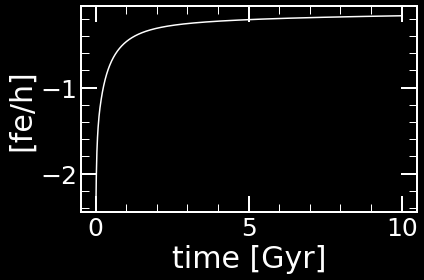

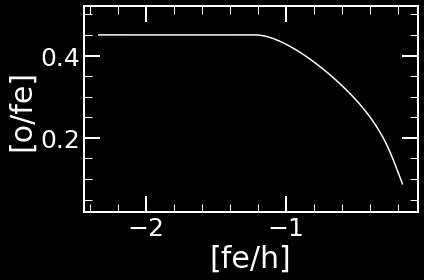

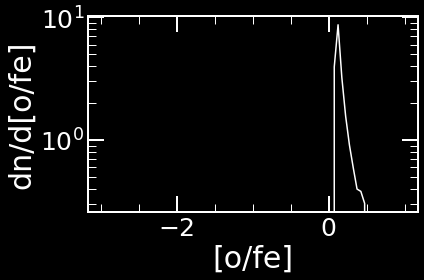

In [28]:
%matplotlib inline 
out.show("[fe/h]") 
out.show("[o/fe]-[fe/h]") 
out.show("dn/d[o/fe]") 

<a id="migration"></a> 
Migration Prescriptions 
------------------------
Before diving into multi-zone models and how to set them up, let's take a look at how VICE allows users to encode their migration prescriptions. This is possible through the ``vice.migration`` module. The simplest way is to make a ``vice.migration.specs`` object and telling it how many zones are in your model. For example, a migration prescription for a five-zone model: 

In [29]:
mig = vice.migration.specs(5) 
print(mig)

Stars: <function _DEFAULT_STELLAR_MIGRATION_ at 0x7fa2682dc9e0>
                      Gas:     MigrationMatrix{
        0 ---------> {0.0, 0.0, 0.0, 0.0, 0.0}
        1 ---------> {0.0, 0.0, 0.0, 0.0, 0.0}
        2 ---------> {0.0, 0.0, 0.0, 0.0, 0.0}
        3 ---------> {0.0, 0.0, 0.0, 0.0, 0.0}
        4 ---------> {0.0, 0.0, 0.0, 0.0, 0.0}
    }



These objects have two attributes: ``stars`` denoting the stellar migration, and ``gas`` denoting the gas migration. The stellar migration prescription must be a function of three variables: the index of the zone a stellar population was born in, the time it formed, and simulation time, in that order. It must then return an integer representing the index of the zone the stellar population is in at that simulation time. If different stellar populations born in the same zone and at the same time are to migrate differently, this function can accept a keyword argument ``n`` as necessary. With this approach, VICE's stellar migration prescription is highly flexible. 

The default function always returns the zone the stellar population formed in, which corresponds to the limiting case in which all stellar populations remain in their zone of birth. 

In [30]:
print(mig.stars(0, 1, 4)) 
print(mig.stars(2, 2.7, 8.3)) 
print(mig.stars(4, 5.6, 10.2)) 

0
2
4


The stellar migration prescription is a matrix coupling each pair of zones. The $ij$'th element represents the fraction of the gas which migrates *from* the $i$'th zone *into* the $j$'th zone in a 10 Myr time interval. At each timestep, the masses of all elements and the gas which migrates will be multiplied by the timestep size $\Delta t$ and divided by 10 Myr; this is added to ensure models with different timestep sizes do not implicitly have stronger or weaker gas migration. Each element of this matrix can be either a number denoting a constant fractional migration rate or a function of time in Gyr denoting time-dependent migration between those two zones. By default, all elements are zero, corresponding to the limiting case where gas does not migrate between zones: 

In [31]:
print(mig.gas) 

MigrationMatrix{
    0 ---------> {0.0, 0.0, 0.0, 0.0, 0.0}
    1 ---------> {0.0, 0.0, 0.0, 0.0, 0.0}
    2 ---------> {0.0, 0.0, 0.0, 0.0, 0.0}
    3 ---------> {0.0, 0.0, 0.0, 0.0, 0.0}
    4 ---------> {0.0, 0.0, 0.0, 0.0, 0.0}
}


Because the diagonal elements would correspond to migration within a single zone, they are irrelevant. In fact, VICE ignores them entirely, adopting them to be zero always, regardless of the user input there. Item assignment to modify the gas migration prescription is simple: by placing 0.1 in the $1,2$ element, 10 percent of the gas in zone 1 will migrate to zone 2 every 10 Myr. Additionally, a function of time can be placed in the $2,3$ element to represent time-dependent migration from zone 2 to zone 3; the values returned from this function will still be multiplied by $\Delta t /$10 Myr. 

In [32]:
def timedep_migration(t): 
    r""" 
    Some function of time describing time-dependent migration between zones. 
    """ 
    return 0.5 * math.exp(-t / 3) 
mig.gas[1][2] = 0.1 
mig.gas[2][3] = timedep_migration 
print(mig.gas) 

MigrationMatrix{
    0 ---------> {0.0, 0.0, 0.0, 0.0, 0.0}
    1 ---------> {0.0, 0.0, 0.1, 0.0, 0.0}
    2 ---------> {0.0, 0.0, 0.0, <function timedep_migration at 0x7fa2c86bf680>, 0.0}
    3 ---------> {0.0, 0.0, 0.0, 0.0, 0.0}
    4 ---------> {0.0, 0.0, 0.0, 0.0, 0.0}
}


<a id="multizonemodels"></a> 
Multi-Zone Models 
-----------------
At its core, VICE's ``multizone`` object is simply an array of ``singlezone`` objects. Users can create them by passing the desired number of zones as the keyword argument ``n_zones``. For example, a five-zone model: 

In [33]:
mz = vice.multizone(name = "example", n_zones = 5) 
print(mz) 

vice.multizone{
    name -----------> example
    n_zones --------> 5
    n_stars --------> 1
    verbose --------> False
    simple ---------> False
    zones ----------> ['zone0', 'zone1', 'zone2', 'zone3', 'zone4']
    migration ------> Stars: <function _DEFAULT_STELLAR_MIGRATION_ at 0x7fa2682dc9e0>
                      Gas:     MigrationMatrix{
        0 ---------> {0.0, 0.0, 0.0, 0.0, 0.0}
        1 ---------> {0.0, 0.0, 0.0, 0.0, 0.0}
        2 ---------> {0.0, 0.0, 0.0, 0.0, 0.0}
        3 ---------> {0.0, 0.0, 0.0, 0.0, 0.0}
        4 ---------> {0.0, 0.0, 0.0, 0.0, 0.0}
    }

}


Below is a table providing a brief description of each attribute: 

| Attribute | Description | 
| --- | --- | 
| name | The name of the output directory, to which VICE will add a ".vice" extension. The output for each individual zone will be stored within this directory. | 
| n_zones | The number of zones in the model. Cannot be modified after creation of the ``multizone`` object. | 
| n_stars | The number of stellar populations VICE should form per zone per timestep. | 
| verbose | If ``True``, VICE will print output to the console as it runs the model. | 
| simple | If ``True``, VICE will run each zone as a one-zone model. This deliberately neglects the migration prescription. | 
| zones | The names of each individual zone. Can be modified by accessing the zone directly. | 
| migration | The ``vice.migration.specs`` object containing this model's migration prescription. | 

Each zone is a ``singlezone`` object, and can be modified with the same freedom as one-zone models. The migration prescription can be modified directly, or swapped for another one entirely. For example: 

In [34]:
mz.zones[0].name = "newname" 
mz.zones[0].tau_star = 5 
mz.zones[0].eta = 1.2 
mz.migration.gas[0][1] = 0.1 
print(mz) 
print(mz.zones[0]) 

vice.multizone{
    name -----------> example
    n_zones --------> 5
    n_stars --------> 1
    verbose --------> False
    simple ---------> False
    zones ----------> ['newname', 'zone1', 'zone2', 'zone3', 'zone4']
    migration ------> Stars: <function _DEFAULT_STELLAR_MIGRATION_ at 0x7fa2682dc9e0>
                      Gas:     MigrationMatrix{
        0 ---------> {0.0, 0.1, 0.0, 0.0, 0.0}
        1 ---------> {0.0, 0.0, 0.0, 0.0, 0.0}
        2 ---------> {0.0, 0.0, 0.0, 0.0, 0.0}
        3 ---------> {0.0, 0.0, 0.0, 0.0, 0.0}
        4 ---------> {0.0, 0.0, 0.0, 0.0, 0.0}
    }

}
vice.singlezone{
    name -----------> newname
    func -----------> <function _DEFAULT_FUNC_ at 0x7fa2682dc4d0>
    mode -----------> ifr
    verbose --------> False
    elements -------> ('fe', 'sr', 'o')
    IMF ------------> kroupa
    eta ------------> 1.2
    enhancement ----> 1.0
    entrainment ----> <entrainment settings>
    Zin ------------> 0.0
    recycling ------> continuous
    delay 

In [35]:
mz.migration = mig 
print(mz) 

vice.multizone{
    name -----------> example
    n_zones --------> 5
    n_stars --------> 1
    verbose --------> False
    simple ---------> False
    zones ----------> ['newname', 'zone1', 'zone2', 'zone3', 'zone4']
    migration ------> Stars: <function _DEFAULT_STELLAR_MIGRATION_ at 0x7fa2682dc9e0>
                      Gas:     MigrationMatrix{
        0 ---------> {0.0, 0.0, 0.0, 0.0, 0.0}
        1 ---------> {0.0, 0.0, 0.1, 0.0, 0.0}
        2 ---------> {0.0, 0.0, 0.0, <function timedep_migration at 0x7fa2c86bf680>, 0.0}
        3 ---------> {0.0, 0.0, 0.0, 0.0, 0.0}
        4 ---------> {0.0, 0.0, 0.0, 0.0, 0.0}
    }

}


In all ``multizone`` models, the "index" of a given zone refers simply to its array-index in the ``multizone.zones`` array. Zone 0 corresponds to ``multizone.zones[0]``, zone 1 to ``multizone.zones[1]``, and so on. Users can set up the evolutionary histories of each individual zone as their model necessitates, and couple them with migration according to the ``vice.migration.specs`` object. Running their model is then as simple as calling ``multizone.run``: 

In [36]:
out = mz.run(np.linspace(0, 10, 1001), capture = True)

Output directory already exists. Overwriting will delete all of its contents, leaving only the results of the current simulation.
Output directory: example.vice
Overwrite? (y | n) y


The keyword arguments ``capture`` and ``overwrite`` perform the exact same functionality for the ``multizone`` object as the ``singlezone`` object. Only now, VICE returns a ``multioutput`` object from the ``multizone`` model, which is at its core an array of ``output`` objects, plus the relevant information on each individual stellar population. Each zones corresponding ``output`` object can be accessed via its name. 

In [37]:
print(out.name) 
print(out.stars) 
print(out.zones["newname"]) 
print(out.zones["zone1"]) 

example
vice.dataframe{
    formation_time -> [0, 0, 0, ... , 10, 10, 10]
    zone_origin ----> [0, 1, 2, ... , 2, 3, 4]
    zone_final -----> [0, 1, 2, ... , 2, 3, 4]
    mass -----------> [1.2e+07, 3e+07, 3e+07, ... , 2.41078e+07, 6.08458e+07, 2.96329e+07]
    z(fe) ----------> [0, 0, 0, ... , 0.000370007, 0.00114626, 0.000890306]
    z(sr) ----------> [0, 0, 0, ... , 7.19353e-09, 3.17026e-08, 2.47453e-08]
    z(o) -----------> [0, 0, 0, ... , 0.00230899, 0.00604476, 0.0047919]
    [fe/h] ---------> [-inf, -inf, -inf, ... , -0.542379, -0.0513077, -0.161051]
    [sr/h] ---------> [-inf, -inf, -inf, ... , -0.818836, -0.174683, -0.282286]
    [o/h] ----------> [-inf, -inf, -inf, ... , -0.393974, 0.023983, -0.0768886]
    [sr/fe] --------> [nan, nan, nan, ... , -0.276457, -0.123375, -0.121236]
    [o/fe] ---------> [nan, nan, nan, ... , 0.148405, 0.0752907, 0.084162]
    [o/sr] ---------> [nan, nan, nan, ... , 0.424862, 0.198666, 0.205398]
    z --------------> [0, 0, 0, ... , 0.00535033

Accessing the data in ``out.zones["newname"]`` and ``out.zones["zone1"]`` proceeds exactly as it did for the ``singlezone`` object, except now the model predictions reflect the user's built-in migration scheme coupling the zones. 

Below is a table providing a brief description of each key in the ``out.stars`` dataframe, which stores the output information for each individual stellar population. 

| Key | Description | 
| --- | --- | 
| formation_time | Simulation time in Gyr at which a stellar population formed. | 
| zone_origin | The index of each stellar population's zone of formation. | 
| zone_final | The index of each stellar population's zone at the present day. | 
| mass | Each stellar population's initial mass in $M_\odot$. | 
| z(x) | The abundance by mass of some element $x$ in that population ($M_x / M_\star$). | 
| [x/h] | The logarithmic abundance by mass relative to the sun of the element $x$. | 
| [x/y] | The logarithmic abundance ratio relative to the sun of the element $x$ to the element $y$. | 
| z | The total abundance by mass, scaled according to the adopted solar composition. | 
| [m/h] | The logarithmic total abundance by mass, scaled in the same way as ``z``: [m/h] = $\log_{10}(Z / Z_\odot)$. | 
| age | The age of each stellar population in Gyr. | 

The ``multioutput.stars`` dataframe shares much of the same functionality as the ``output.history`` instances of these dataframes. For example: 

In [38]:
print(out.stars['[o/fe]'][-10]) 
print(out.stars['[fe/o]'][-10]) 
print(out.stars[-1]) 

0.11768374468931368
-0.11768374468931368
vice.dataframe{
    formation_time -> 10.0
    zone_origin ----> 4.0
    zone_final -----> 4.0
    mass -----------> 29632900.0
    z(fe) ----------> 0.0008903057
    z(sr) ----------> 2.474527e-08
    z(o) -----------> 0.004791897
    [fe/h] ---------> -0.16105055643268462
    [sr/h] ---------> -0.282286144837462
    [o/h] ----------> -0.07688855430583957
    [sr/fe] --------> -0.12123558840477738
    [o/fe] ---------> 0.08416200212684505
    [o/sr] ---------> 0.20539759053162243
    z --------------> 0.011348166380983385
    [m/h] ----------> -0.09120234110524574
    age ------------> 0.0
}


<a id="multizonemodels_milkyway"></a> 
Milky Way Models 
----------------
VICE provides the ``vice.milkyway`` object, which is a subclass of the ``multizone`` object designed specifically for modeling Milky Way like galaxies. This is the object employed in running the Johnson et al. (2021) multi-zone models. It enforces a multi-ring approach, in which each zone corresponds to a given annulus of the Milky Way disk. Zone 0 is the innermost zone at $R$ = 0, and the final zone will extend to at least $R$ = 20 kpc. By default, it adopts the stellar migration prescription informed from the ``h277`` simulation encodes in the ``vice.toolkit.hydrodisk.hydrodiskstars`` object, their star formation law, and their scaling of the mass loading factor $\eta$ with radius. To create one, simply tell it the desired width of each annulus and an approximate number of star particles you need from the ``h277`` simulation: 

In [39]:
mw = vice.milkyway(zone_width = 1.0, N = 2e5) 
print(mw) 

vice.milkyway{
    name -----------> milkyway
    n_zones --------> 20
    n_stars --------> 1
    verbose --------> False
    simple ---------> False
    annuli ---------> [0, 1, 2, ... , 18, 19, 20]
    evolution ------> <function milkyway.default_evolution at 0x7fa22815bdd0>
    mode -----------> ifr
    elements -------> ('fe', 'sr', 'o')
    IMF ------------> kroupa
    mass_loading ---> <function milkyway.default_mass_loading at 0x7fa22815d320>
    dt -------------> 0.01
    bins -----------> [-3, -2.95, -2.9, ... , 0.9, 0.95, 1]
    delay ----------> 0.15
    RIa ------------> plaw
    smoothing ------> 0.0
    tau_ia ---------> 1.5
    m_upper --------> 100.0
    m_lower --------> 0.08
    postMS ---------> 0.1
    Z_solar --------> 0.014
}


Each attribute of the ``milkyway`` object corresponds to attributes of either ``multizone`` or ``singlezone`` objects, each simply brought to the front so they can be modified across all zones. For example, ``mw.dt = 0.02`` is the same as ``for zone in mw.zones: zone.dt = 0.02``. There are a few attributes with new names, however: ``annuli``, ``evolution``, and ``mass_loading``. 

``annuli`` simply stores the edges of each annulus of the model. Under the current example, $R$ = 0 to $R$ = 1 kpc is described by ``mw.zones[0]``, $R$ = 1 kpc to $R$ = 2 kpc is described by ``mw.zones[1]``, and so on. 

``evolution`` stores a function of radius and time describing either the surface density of infall in $M_\odot$ kpc$^{-2}$ yr$^{-1}$, the surface density of star formation in $M_\odot$ kpc$^{-2}$ yr$^{-1}$, or the surface density of gas in $M_\odot$ kpc$^{-2}$. The interpretation is again set by the attribute ``mode``. Setting this attribute will modify the ``func`` attributes of each zone accordingly, taking into account their surface area to construct the required function describing the evolution in terms of mass rather than surface density. Users should be aware that this is the *only* component of VICE which allows users to formulate their equations in terms of surface density, and that they may still modify each zone's ``func`` attribute after specifying all of them via this attribute in order to make special modifications. 

``mass_loading`` is a function of radius $R$ in kpc describing the value of the mass loading factor $\eta$ in those annuli, assuming the center of each annulus to provide the exact value of $R$. Although users may assign the value of $\eta$ to all zones given this function, they're still able to modify individual zones to make special modifications. 

The ``milkyway`` object inherits the ``run`` function from the ``multizone`` class, meaning that it, and reading in the output, proceed exactly as before. Users should be aware however that even though they may specify the evolutionary history in terms of a surface density, *all* output will be in terms of mass with units of $M_\odot$, rather than surface densities with units of $M_\odot$ kpc$^{-2}$. 

In [40]:
mw.dt = 0.05 
out = mw.run(np.linspace(0, 10, 1001), capture = True)

Output directory already exists. Overwriting will delete all of its contents, leaving only the results of the current simulation.
Output directory: milkyway.vice
Overwrite? (y | n) y


In [41]:
print(out.zones["zone0"]) 
print(out.stars) 

<VICE output from singlezone: milkyway.vice/zone0>
vice.dataframe{
    formation_time -> [0, 0, 0, ... , 10, 10, 10]
    zone_origin ----> [0, 1, 2, ... , 17, 18, 19]
    zone_final -----> [0, 3, 3, ... , 17, 18, 19]
    mass -----------> [7.50957e-29, 3.48041e-29, 2.43409e-29, ... , 54977.2, 58114, 61254.1]
    z(fe) ----------> [0, 0, 0, ... , 1.05543e-08, 0, 0]
    z(sr) ----------> [0, 0, 0, ... , 2.00907e-13, 0, 0]
    z(o) -----------> [0, 0, 0, ... , 7.86982e-08, 0, 0]
    [fe/h] ---------> [-inf, -inf, -inf, ... , -5.08716, -inf, -inf]
    [sr/h] ---------> [-inf, -inf, -inf, ... , -5.37278, -inf, -inf]
    [o/h] ----------> [-inf, -inf, -inf, ... , -4.86143, -inf, -inf]
    [sr/fe] --------> [nan, nan, nan, ... , -0.285623, nan, nan]
    [o/fe] ---------> [nan, nan, nan, ... , 0.225729, nan, nan]
    [o/sr] ---------> [nan, nan, nan, ... , 0.511352, nan, nan]
    z --------------> [0, 0, 0, ... , 1.78249e-07, 0, 0]
    [m/h] ----------> [-inf, -inf, -inf, ... , -4.8951, -inf, 

<a id="useful_data"></a> 
Useful Built-in Data 
--------------------
VICE makes much of its internal data directly accessible to users. First and foremost are built-in instances of the ``dataframe``: 

- ``atomic_number``: The proton number of each element.
- ``solar_z``: The abundance by mass of each element in the sun. 
- ``sources``: The dominant astrophysical production sites of each element as reported by Johnson (2019), Science, 363, 474 
- ``stable_isotopes``: The isotopes of each element which are not radioactive. 

The ``solar_z`` dataframe encodes the solar abundances which VICE will adopt in its chemical evolution simulations. By default, it adopts the Asplund et al. (2009), ARA&A, 47, 481 photospheric values (with the exception of helium, for which it adopts their derived bulk abundance). The values stored there can be modified however users see fit, and changes will be reflected in chemical evolution simulations (but be careful to also modify the ``Z_solar`` attribute of the ``singlezone`` class if necessary). 

In [42]:
print(vice.atomic_number['o']) 
print(vice.solar_z['mg']) 
print(vice.stable_isotopes['fe']) 

8
0.000706
[54, 56, 57, 58]


Thank You! 
==========

We hope you found this tutorial helpful! Remember that VICE's documentation can be found at https://vice-astro.readthedocs.io/en/latest/, and that simply running ``vice --docs`` from a ``Unix`` terminal will launch this web page automatically. 